 ## 1. Introduction

The goal of this notebook is to carry out the A/B test whose objective was formulated as to decide whether the free trial subscription model was successful compared to the subscription model that doesn't offer free trial. 

A/B testing, at its most basic, is a way to compare two versions of some system to understand which of them performs better. In our case we compare two possible sets of subscription options. Success or "better performance" criteria will have something to do with the users' reaction to them. These criteria were not defined in the task, so we will define them later, after we have seen the data.

An ideal A/B test assumes that the only difference between the two versions of the system is the presence or the absence of a "treatment" effect (in our case - free trial option). Every observation in the data available to us is assigned to one of the groups ("treatment" or "control"). If it turns out that factors other than the trial option may have also played a role in different performance of the two versions, this can considerably limit the power of the obtained results.  

The rest document is structured as follows. First we carry out some exploratory and plausbility analysis and perform certain data transormations. After that, we more formally specify the A/B test and carry it out. Finally, we discuss the results.

In [1]:
# Load necessary libraries

# Pandas and numpy to analyse and transform data
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Graphics
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Statistical tests
from statsmodels.stats.proportion import proportions_ztest     
from statsmodels.stats.weightstats import ttest_ind 

# Multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Finally, let us convert the three tables to dataframes

In [2]:
users = pd.read_csv('data/users.csv', parse_dates=[1])
purchases = pd.read_csv('data/purchases.csv', parse_dates=[3])
abtest_assignments = pd.read_csv('data/abtest_assignments.csv', parse_dates=[2])

## 2. Exploratory analysis

Let us have a look at each of the three tables in turn.

In [3]:
users.head()
users.info()
print('user_id is unique: ', users['user_id'].is_unique) # check if user_id can be used as a key

,user_id,signup_date
0,u0000001,2019-06-18 08:31:44.527
1,u0000002,2019-06-15 08:02:51.137
2,u0000003,2019-06-11 15:30:01.531
3,u0000004,2019-06-10 03:26:28.476
4,u0000005,2019-06-22 18:42:32.667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28897 entries, 0 to 28896
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      28897 non-null  object        
 1   signup_date  28897 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 451.6+ KB
user_id is unique:  True


In [4]:
users.set_index('user_id', inplace=True) # since user_id is unique, let's use it as the index
users.sort_index(inplace=True)

Let us look at the purhases table:

In [5]:
purchases.sort_values(['user_id', 'purchased_at'], inplace=True) # sorting the values right away seems sensible
# In this way all purchases are positionally "grouped" by user and are in the chronological order for each user.
purchases.head()
purchases.info()

,user_id,plan_id,purchase_type,purchased_at,amount
120,u0000002,12-months,sale,2019-06-28 08:18:30,20.35
654,u0000003,6-months,trial,2019-06-11 15:30:19,NaN
639,u0000011,6-months,trial,2019-06-06 19:44:05,NaN
500,u0000017,12-months,sale,2019-06-12 10:49:33,20.54
141,u0000050,1-month,sale,2019-06-09 08:54:26,4.30


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1919 entries, 120 to 768
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        1919 non-null   object        
 1   plan_id        1919 non-null   object        
 2   purchase_type  1919 non-null   object        
 3   purchased_at   1919 non-null   datetime64[ns]
 4   amount         1061 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 90.0+ KB


"None" values in the "amount" column correspond to "trial" purchases and vice versa:

In [6]:
purchases[purchases['amount'].isna()]['purchase_type'].unique()
purchases[purchases['purchase_type'] == 'trial']['amount'].unique()

array(['trial'], dtype=object)

array([nan])

In [7]:
purchases[purchases['amount'] == 0] # The column "amount" has no zero values.

,user_id,plan_id,purchase_type,purchased_at,amount


Let us replace None with 0 in the "amount" column for the sake of convenience, this will not lead to confusion because there are no 0 values in this column.

In [8]:
purchases.loc[purchases['amount'].isna(), 'amount'] = 0

We know that in the purchases table user_id values are not unique because some users made at least two purchases (a trial purchase and a "real" purchase). Let's find out if two purchases is the maximum.

In [9]:
purchases['user_id'].value_counts().sort_values(ascending=False).head()

u0009879    2
u0017412    2
u0006506    2
u0013883    2
u0021732    2
Name: user_id, dtype: int64

This means that each user has at most two rows in the table (made at most two purchases).

In [10]:
purchases['amount'] = purchases['amount'].astype('float32') # it was initially read as an object, not as a numeric type

Let's create a column that for each purchase shows its number (first or second) for each user. Since the rows are sorted by user_id and time of purchase, the application of the "duplicated" method will lead to the situation where the first of the two "duplicate" rows as defined based on the user_id, will be marked as non-duplicate (value FALSE), the second one will be marked as duplicate (value TRUE). We convert these values to 1 and 2 respectively.

In [11]:
purchases['purchase_number'] = purchases['user_id'].duplicated().astype('int16') +1

In [12]:
purchases.head()

,user_id,plan_id,purchase_type,purchased_at,amount,purchase_number
120,u0000002,12-months,sale,2019-06-28 08:18:30,20.350000,1
654,u0000003,6-months,trial,2019-06-11 15:30:19,0.000000,1
639,u0000011,6-months,trial,2019-06-06 19:44:05,0.000000,1
500,u0000017,12-months,sale,2019-06-12 10:49:33,20.540001,1
141,u0000050,1-month,sale,2019-06-09 08:54:26,4.300000,1


In [13]:
purchases.set_index(['user_id', 'purchase_number'], inplace=True) # needed to enable the next command
purchases = purchases.unstack(level=1)  # reshapes the table to have all information on one user in one row
# This will lead to new NaN values
purchases.head()

plan_id      purchase_type             purchased_at      \
purchase_number          1    2             1    2                   1   2   
user_id                                                                      
u0000002         12-months  NaN          sale  NaN 2019-06-28 08:18:30 NaT   
u0000003          6-months  NaN         trial  NaN 2019-06-11 15:30:19 NaT   
u0000011          6-months  NaN         trial  NaN 2019-06-06 19:44:05 NaT   
u0000017         12-months  NaN          sale  NaN 2019-06-12 10:49:33 NaT   
u0000050           1-month  NaN          sale  NaN 2019-06-09 08:54:26 NaT   

                    amount      
purchase_number          1   2  
user_id                         
u0000002         20.350000 NaN  
u0000003          0.000000 NaN  
u0000011          0.000000 NaN  
u0000017         20.540001 NaN  
u0000050          4.300000 NaN

Now for each original column we have two columns, 1 and 2 correspond to the client's purchase number. Some users have no purchases, some have just purchase 1, and some have purchases 1 and 2.

In [14]:
# Change the hierarchy of column names for the sake of convenience
purchases.columns = pd.Index([e[0] + "_" + str(e[1]) for e in purchases.columns.tolist()])
purchases.head()

,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,
u0000002,12-months,NaN,sale,NaN,2019-06-28 08:18:30,NaT,20.350000,NaN
u0000003,6-months,NaN,trial,NaN,2019-06-11 15:30:19,NaT,0.000000,NaN
u0000011,6-months,NaN,trial,NaN,2019-06-06 19:44:05,NaT,0.000000,NaN
u0000017,12-months,NaN,sale,NaN,2019-06-12 10:49:33,NaT,20.540001,NaN
u0000050,1-month,NaN,sale,NaN,2019-06-09 08:54:26,NaT,4.300000,NaN


In [15]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1602 entries, u0000002 to u0028848
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   plan_id_1        1602 non-null   object        
 1   plan_id_2        317 non-null    object        
 2   purchase_type_1  1602 non-null   object        
 3   purchase_type_2  317 non-null    object        
 4   purchased_at_1   1602 non-null   datetime64[ns]
 5   purchased_at_2   317 non-null    datetime64[ns]
 6   amount_1         1602 non-null   float32       
 7   amount_2         317 non-null    float32       
dtypes: datetime64[ns](2), float32(2), object(4)
memory usage: 100.1+ KB


In [16]:
purchases[purchases['purchase_type_2'].notna()]['purchase_type_1'].unique()

array(['trial'], dtype=object)

Only 317 users made a second purchase, and in all these cases the first purchase was a trial purchase.

Now let's turn to the assignments table

In [17]:
abtest_assignments.head()
abtest_assignments.info()
print('user_id is unique: ', abtest_assignments['user_id'].is_unique) # check if user_id can be used as a key

,user_id,variant,assigned_at
0,u0007000,CONTROL,2019-06-11 18:45:56.764299
1,u0011978,CONTROL,2019-06-14 23:18:09.803367
2,u0028533,TREATMENT,2019-06-22 09:25:38.101405
3,u0008785,TREATMENT,2019-06-12 20:21:23.229213
4,u0028276,TREATMENT,2019-06-06 23:30:26.202468


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28897 entries, 0 to 28896
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      28897 non-null  object        
 1   variant      28897 non-null  object        
 2   assigned_at  28897 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 677.4+ KB
user_id is unique:  True


In [18]:
abtest_assignments.set_index('user_id', inplace=True) # Let's then use user_id as an index (like in the users table).
abtest_assignments.sort_index(inplace=True)

Let's check if the user_id values are consistent among the three tables:

Indices (they are now the user_id columns) of abtest_assignments and users coincide:

In [19]:
abtest_assignments.index.equals(users.index)

True

And the user_id values contained in the purchases table are contained in both of them:

In [20]:
purchases.index.isin(users.index).mean() # if some indices were not containd in users, the result would have been <1

1.0

Join all three tables on 'user_id'. Since the indices on users and abtest_assignments coincide, in effect it doesn't matter if we perform an inner or an outer join. After they are joined, the result is then left joined with purchases so that we keep all available user_id values. New NaN values have to appear in the "purchases" columns.

In [21]:
data = users.join(abtest_assignments, on='user_id').join(purchases, on='user_id')
data.head()

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0000001,2019-06-18 08:31:44.527,CONTROL,2019-06-18 08:31:46.601464,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0000002,2019-06-15 08:02:51.137,CONTROL,2019-06-15 08:02:51.960849,12-months,NaN,sale,NaN,2019-06-28 08:18:30,NaT,20.35,NaN
u0000003,2019-06-11 15:30:01.531,TREATMENT,2019-06-11 15:30:04.799228,6-months,NaN,trial,NaN,2019-06-11 15:30:19,NaT,0.00,NaN
u0000004,2019-06-10 03:26:28.476,TREATMENT,2019-06-10 03:26:15.107651,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0000005,2019-06-22 18:42:32.667,CONTROL,2019-06-22 18:42:33.685683,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN


At this point let's summarise that for each user we have the following data:
- his signup timestamp, 
- the timestamp of his assigment to one of the two groups (treatment or control), 
- the name of this group, 

For each of the user's two possible purchases either we have data on it (plan_id, purchase type: trial or sale, timestamp and the revenue) or this data is missing (which means that the corresponding purchase didn't take place).

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28897 entries, u0000001 to u0028897
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   signup_date      28897 non-null  datetime64[ns]
 1   variant          28897 non-null  object        
 2   assigned_at      28897 non-null  datetime64[ns]
 3   plan_id_1        1602 non-null   object        
 4   plan_id_2        317 non-null    object        
 5   purchase_type_1  1602 non-null   object        
 6   purchase_type_2  317 non-null    object        
 7   purchased_at_1   1602 non-null   datetime64[ns]
 8   purchased_at_2   317 non-null    datetime64[ns]
 9   amount_1         1602 non-null   float32       
 10  amount_2         317 non-null    float32       
dtypes: datetime64[ns](4), float32(2), object(5)
memory usage: 2.4+ MB


Now let us perform several plausbility checks. Let us start with different time stamps. First, let us analyse how soon after the signup the users were assigned to the groups.

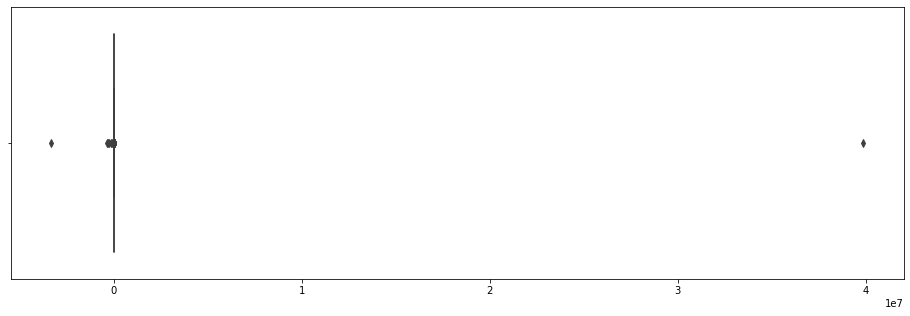

In [23]:
fig, axs = plt.subplots(figsize=(16,5))
sns.boxplot((data['assigned_at'] - data['signup_date']).apply(lambda x: x.total_seconds()), ax=axs);

It turns out that though most users were assigned to groups roughly at the time of the signup (difference between the timestamps is rougly 0), some were assigned before the signup, and some considerably later. Let us investigate the extreme points.

In [24]:
# First, let's identify the users assigned more than a minute after the signup
signup_assign_diff = (data['assigned_at'] - data['signup_date']).apply(lambda x: x.total_seconds())
signup_assign_diff[signup_assign_diff>60]

user_id
u0000815    1.037186e+02
u0011169    8.601647e+01
u0018580    6.443725e+01
u0018954    3.984929e+07
dtype: float64

In [25]:
data.loc[['u0018954'], :]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0018954,2018-03-18 12:35:20.206,TREATMENT,2019-06-22 17:50:07.748035,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN


3 users were assigned to a group 64 to 103 seconds after the sign-up, which is tolerable (we can assume they will not want to purchase within one minute of the signup so that they will have a chance to see a trial option).
One user was assigned to a treatment group 3 months after the signup, the reason for which is unclear and unknown. This can be interpreted as giving him access to a free trial only three months after the signup. This means that this user cannot be considered as part of the treatment group and cannot be considered in the A/B test because his actions were probably affected by the initial absence of the trial option.

In [26]:
implaus_idx_1 = ['u0018954'] 
# save the user_id of this user in the list of "implausible indices"

In [27]:
(signup_assign_diff[signup_assign_diff<0]).shape # number of users who were assigned to a group before the signup

(9686,)

Almost 10000 out of roughly 29000 users were assigned to a group before the signup, which seems quite implausible. If a user is actually identified and assigned to a group as soon as he visits the website for the first time (but not necessarily signs up), this is likely to reduce the power of the A/B test exactly because at that time we don't know yet if the user will actually sign up. In our data all such users have signed up eventually, so the presence of these cases in the sample can have several explanations (e.g. the assignment takes place as soon as the user visits the website for the first time, but these groups are large enough in order to guarantee that there will be enough users in each group even after the signup and from these groups random samples of the necessary size can be drawn - but this can skew the randomness of these samples and limit the power of the test). In any case this is the implausbility that in a real business situation should be clarified before proceeding without having to make any assumptions.

Let us analyse how long before the signup the users were assigned to a group.

In [28]:
neg_timedelta = signup_assign_diff[signup_assign_diff<0]
neg_timedelta.describe()

count    9.686000e+03
mean    -4.576285e+02
std      3.416330e+04
min     -3.320115e+06
25%     -1.323010e+00
50%     -6.654850e-01
75%     -2.761933e-01
max     -7.100000e-05
dtype: float64

Let us cut the time difference between signup and assigment into intervals and look at the distribution table.

In [29]:
bins_neg_timedelta = pd.cut(signup_assign_diff, bins=[signup_assign_diff.min(), 
                                                 -10000, -1000, -100, -50, -20, -10, -5, 0], right=False)
bins_neg_timedelta.value_counts()

[-5.0, 0.0)                8890
[-20.0, -10.0)              293
[-50.0, -20.0)              267
[-10.0, -5.0)               119
[-100.0, -50.0)              68
[-1000.0, -100.0)            41
[-3320115.28, -10000.0)       6
[-10000.0, -1000.0)           2
dtype: int64

The least numerous, but the most extreme groups correspond to the assigment of more than 1000 seconds (and up to 8 days) before the signup. As mentioned above, we in fact should not take into account any of these 9686 cases before understanding the reason of this implausibility. Having only limited information the best solution seems to be to discard only the most implausible observations (signup_assign_diff < -1000, the threshold of 1000 seconds is chosen more or less arbitrarily) and to assume that the rest of the data is plausible.

In [30]:
# save these user_id values in another list of "implausible indices"
implaus_idx_2 = (signup_assign_diff[signup_assign_diff<-1000]).index
data.loc[implaus_idx_2, :]  

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0002503,2019-06-22 02:16:13.424,CONTROL,2019-06-22 01:45:21.467663,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0006144,2019-06-23 08:30:30.782,TREATMENT,2019-06-20 13:52:47.266009,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0006545,2019-06-10 21:45:31.730,TREATMENT,2019-06-10 00:53:43.046668,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0006829,2019-06-23 18:56:49.804,TREATMENT,2019-06-20 06:15:20.652638,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0008709,2019-07-29 11:32:22.969,TREATMENT,2019-06-21 01:17:07.689477,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0010506,2019-06-18 06:04:08.320,TREATMENT,2019-06-18 05:27:17.301555,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0014899,2019-06-23 15:46:14.629,TREATMENT,2019-06-22 06:11:23.176687,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
u0026735,2019-06-21 08:05:09.409,TREATMENT,2019-06-17 11:13:11.408973,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN


Let us analyse the time difference between the signup and the first purchase. 

count                        1602
mean       8 days 03:20:49.102003
std       27 days 11:42:32.351826
min        0 days 00:00:07.459000
25%        0 days 00:00:25.151250
50%        0 days 00:01:39.344500
75%        0 days 18:28:28.180000
max      181 days 00:11:27.879000
dtype: object

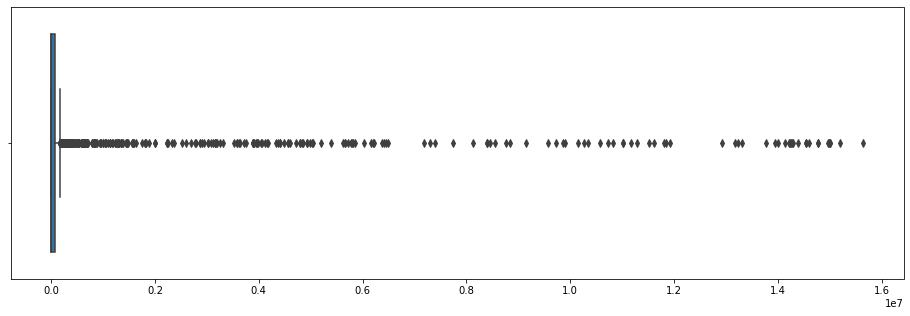

In [31]:
purchase_signup_timediff = (data['purchased_at_1'] - data['signup_date'])
purchase_signup_timediff.describe()
fig, axs = plt.subplots(figsize=(16,5))
sns.boxplot(purchase_signup_timediff.apply(lambda x: x.total_seconds()), ax=axs)

It takes the majority (75%) of the users who make at least one purchase less than a day to make the first purchase (trial or a "real" purchase). But it can take some users as long as 181 days.

Now let us analyse the time difference between the second and the first purchase

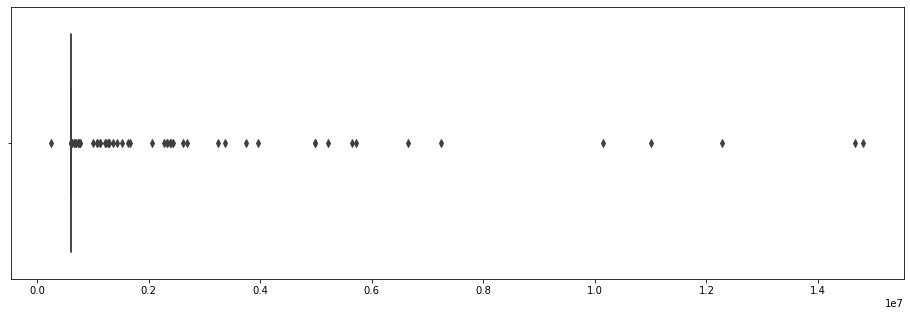

In [32]:
purchase2_purchase1_timediff = (data['purchased_at_2'] - data['purchased_at_1'])
fig, axs = plt.subplots(figsize=(16,5))
sns.boxplot(purchase2_purchase1_timediff.apply(lambda x: x.total_seconds()), ax=axs)
#purchase2_purchase1_timediff.apply(lambda x: x.total_seconds()).hist()

The second purchase refers to making a "real" purchase after subscribing to a trial version, whether by not cancelling the trial version or by making a deliberate purchase before or after the end of the trial period. As we can see below in the vast majority of cases the second purchase occured exactly 7 days after the trial subscription ("automatic" second purchase), this correspond to the vertical line in the boxplot above. But it can take some users much longer to decide to use the paid version (up to several weeks).

In [33]:
purchase2_purchase1_timediff.value_counts(dropna=False).head(7)

NaT                 28580
7 days 00:00:00       262
7 days 02:48:22         2
26 days 22:48:39        2
8 days 21:53:17         1
27 days 15:32:18        1
23 days 20:36:16        1
dtype: int64

Let us now have a look at the distribution of treatment and control users for each of the three cases: no transaction, only one transaction in the test period, 2 transactions in the test period (the first being trial).

In [34]:
# no transaction
data[data['plan_id_1'].isna()]['variant'].value_counts(dropna=False)

CONTROL      13867
TREATMENT    13428
Name: variant, dtype: int64

In [35]:
# just one transaction in the test period 
data[(data['plan_id_1'].notna()) & (data['plan_id_2'].isna())]['variant'].value_counts(dropna=False)

TREATMENT    836
CONTROL      449
Name: variant, dtype: int64

In [36]:
# two transactions in the test period - only treatment users are expected since only they have access to free trial
data[data['plan_id_2'].notna()]['variant'].value_counts(dropna=False)

TREATMENT    315
CONTROL        2
Name: variant, dtype: int64

The two "control" users that made two purchases is an implausibility. Let us have a look at the full records for these users.

In [37]:
data[(data['plan_id_2'].notna()) & (data['variant'] == 'CONTROL')]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0007615,2019-06-22 14:39:26.118,CONTROL,2019-06-22 14:39:27.787594,6-months,12-months,trial,sale,2019-06-24 08:03:00,2019-07-01 10:51:22,0.0,26.98
u0008698,2019-06-20 13:54:53.715,CONTROL,2019-06-20 13:54:52.269679,6-months,6-months,trial,sale,2019-06-20 13:59:45,2019-06-27 13:59:45,0.0,12.83


Since this is an obvious implausibility and we don't know how to treat it (whether the assignment labels are wrong and these users are actually part of the treatment group, or perhaps trial purchases in these cases actually didn't occur and should be ignored), we will discard both users.

In [38]:
implaus_idx_3 = data[(data['plan_id_2'].notna()) & (data['variant'] == 'CONTROL')].index

Let us do a similar distribution analysis for the purchase types. Let us get some better understanding of what purchase types are possible if a user made just one or two purchases. We have seen above that for each user who made two purchases in the test period the first one is a "trial" purchase. Let us make sure that the second one is always a sale.

In [39]:
# the second transction is always a sale
data[(data['plan_id_1'].notna()) & (data['plan_id_2'].notna())]['purchase_type_2'].unique()

array(['sale'], dtype=object)

If there is just one transaction, it should be able to be either a trial or a sale

In [40]:
# just one transaction in the test period 
data[(data['plan_id_1'].notna()) & (data['plan_id_2'].isna())]['purchase_type_1'].value_counts(dropna=False)

sale     744
trial    541
Name: purchase_type_1, dtype: int64

But if we split this between treatment and control group, we conclude that while it is possible that some treatment users make an immediate "real" purchase rather than trying a trial version, it is again implausible that one control user had access to a trial option. We will discard this user, too.

In [41]:
data[(data['plan_id_1'].notna()) & (data['plan_id_2'].isna()) & 
                 (data['variant'] == 'TREATMENT' )]['purchase_type_1'].value_counts(dropna=False)

trial    540
sale     296
Name: purchase_type_1, dtype: int64

In [42]:
data[(data['plan_id_1'].notna()) & (data['plan_id_2'].isna()) & 
                 (data['variant'] == 'CONTROL' )]['purchase_type_1'].value_counts(dropna=False)

sale     448
trial      1
Name: purchase_type_1, dtype: int64

In [43]:
implaus_idx_4 = data[(data['plan_id_1'].notna()) & (data['plan_id_2'].isna()) & (data['purchase_type_1'] == 'trial') & 
                 (data['variant'] == 'CONTROL' )].index

Let us view the records for this user

In [44]:
data.loc[implaus_idx_4, :]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0010537,2019-06-22 06:58:47.257,CONTROL,2019-06-22 06:58:48.411621,6-months,NaN,trial,NaN,2019-11-03 14:53:53,NaT,0.0,NaN


Let us also analyse the distribution of the purchase plans. Let's see how it is distributed depending on the purchase type (trial vs. sale) for the treatment and control groups separately. Let's do it first for the first purchase and then for the second purchase.

First purchase:

In [45]:
# Treatment group
pd.pivot_table(data[data['variant'] == 'TREATMENT'][['plan_id_1', 'purchase_type_1', 'purchased_at_1']], 
               values = 'purchased_at_1', index='plan_id_1', columns='purchase_type_1', aggfunc='count')

purchase_type_1,sale,trial
plan_id_1,,
1-month,192.0,NaN
12-months,90.0,NaN
6-months,12.0,855.0
lifetime,2.0,NaN


In [46]:
# Control group
pd.pivot_table(data[data['variant'] == 'CONTROL'][['plan_id_1', 'purchase_type_1', 'purchased_at_1']], 
               values = 'purchased_at_1', index='plan_id_1', columns='purchase_type_1', aggfunc='count')

purchase_type_1,sale,trial
plan_id_1,,
1-month,267.0,NaN
12-months,160.0,NaN
6-months,18.0,3.0
lifetime,3.0,NaN


Second purchase

In [47]:
# Second purchase - treatment group
pd.pivot_table(data[data['variant'] == 'TREATMENT'][['plan_id_2', 'purchase_type_2', 'purchased_at_2']], 
               values = 'purchased_at_2', index='plan_id_2', columns='purchase_type_2', aggfunc='count')

purchase_type_2,sale
plan_id_2,
1-month,18
12-months,8
3-months,1
6-months,288


In [48]:
# Second purchase - control group
pd.pivot_table(data[data['variant'] == 'CONTROL'][['plan_id_2', 'purchase_type_2', 'purchased_at_2']], 
               values = 'purchased_at_2', index='plan_id_2', columns='purchase_type_2', aggfunc='count')

purchase_type_2,sale
plan_id_2,
12-months,1
6-months,1


We see that apparently only 6-month plans are offered as trial plans. But this is largely a fictitious name for a trial plan because the trial period ends in a week anyway, and then the user implicitly (by not cancelling) or explicitly (by cancelling and subscribing) chooses the plan he subscribes to next (we can see in the table on second purchases for the treatment group that the users could choose more than one plan). It is interesting to note that the 3-months plan was chosen only once, possibly because it was not offered to all users at all times. We can also see the implausible cases we have identified above (3 trial purchases and 2 seconds purchases in the control group).
Overall, the 6-month plan seems to be the most popular one (when only "real sale" transactions are considered), followed by 1-month and 12-month plans.

Let us analyse now what  recorded revenues correspond to different subscription plans. Our naive expectation is that if a plan assumes a one-time payment, it should be equal for all users who subscribed to this subscription plan. If a plan assumes monthly payments, the revenues for this plan should be divisible by a monthly payment for this plan (which should be the same for all users who subscribed to this subscription plan). At the moment we don't know if any of the plans assume monthly payments and how in such cases the revenues are reflected in our table.

Previously we replaced the None values for the trial revenues with zeros. We have now more NaN values in the amount columns because certain users didn't make any purchase or made just one. Let us replace those NaN values by zeros as well.

Let us first analyse the revenue corresponding to the first (or the only) purchase. Let us have a look at the boxplots.

In [49]:
data.fillna({'amount_1': 0, 'amount_2': 0}, inplace=True)

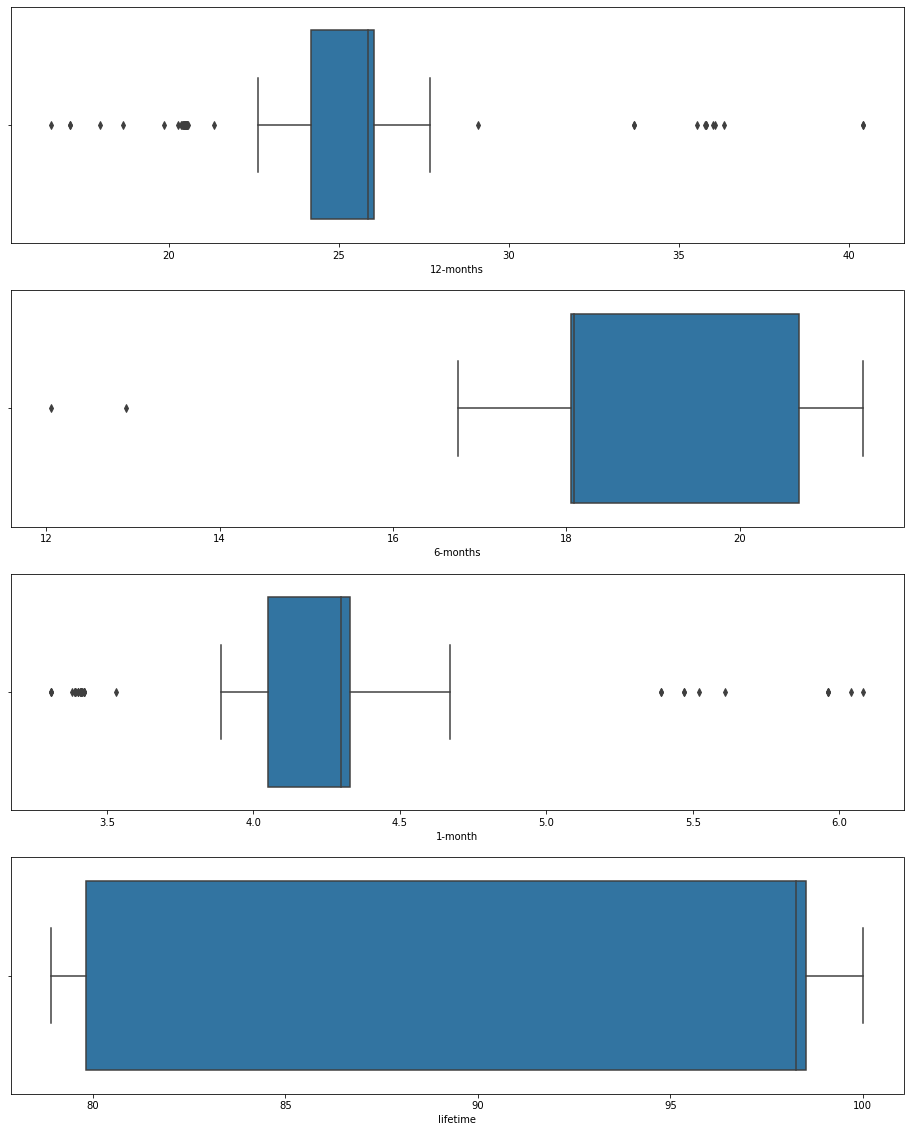

In [50]:
fig, axs = plt.subplots(4,1, figsize=(16,20))
i = 0
for val in data['plan_id_1'].unique():
    if pd.Series(val).isna().sum() == 0:
        sns.boxplot(data[(data['purchase_type_1'] == 'sale')  & (data['plan_id_1'] == val)]['amount_1'], ax=axs[i])
        axs[i].set(xlabel=val)
        i += 1
pass;

We can see that the revenue can be in fact quite different even for the same subscription plan. This seems implausible at first sight. The revenues corresponding to the 1-month plan range from around 3 to around 6 units (we will refer to the monetary units as "units" since we have no official information on that) even though the day on which the subscription should have begun can almost coincide (see below, purchased_at_1 is around middle of June). One possible explanation is that for some reason different prices were offered to different users (possibly as part of other A/B tests). Another possible explanation is that the revenue reflects other transactions not present in the table (such as prolongation of the 1-month subscription). In this case it is still not clear why revenues are not divisible by the same number. Some variation can also be caused by currency conversion at different exchange rates. 

In [51]:
data[(data['plan_id_1'] == '1-month') & (data['amount_1'] < 3.4)]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0003568,2019-06-12 18:06:24.312,TREATMENT,2019-06-12 18:06:25.674428,1-month,NaN,sale,NaN,2019-06-18 18:12:57,NaT,3.39,0.0
u0005826,2019-06-11 21:33:12.975,TREATMENT,2019-06-11 21:33:10.922176,1-month,NaN,sale,NaN,2019-06-25 13:34:29,NaT,3.39,0.0
u0005894,2019-06-23 11:29:10.978,CONTROL,2019-06-23 11:29:12.067706,1-month,NaN,sale,NaN,2019-06-26 17:17:03,NaT,3.39,0.0
u0011703,2019-06-18 15:43:48.270,TREATMENT,2019-06-18 15:43:48.260852,1-month,NaN,sale,NaN,2019-06-18 15:45:01,NaT,3.39,0.0
u0015787,2019-06-20 10:11:57.693,CONTROL,2019-06-20 10:11:57.719291,1-month,NaN,sale,NaN,2019-08-17 15:48:44,NaT,3.31,0.0
u0016908,2019-06-21 17:11:51.497,CONTROL,2019-06-21 17:11:52.559943,1-month,NaN,sale,NaN,2019-06-21 17:32:25,NaT,3.39,0.0
u0020927,2019-06-10 09:37:08.647,CONTROL,2019-06-10 09:37:08.165592,1-month,NaN,sale,NaN,2019-07-11 15:19:32,NaT,3.38,0.0
u0021959,2019-06-14 21:29:09.376,CONTROL,2019-06-14 21:29:08.210378,1-month,NaN,sale,NaN,2019-07-31 14:54:18,NaT,3.31,0.0
u0022125,2019-06-22 23:34:37.918,CONTROL,2019-06-22 23:34:38.825983,1-month,NaN,sale,NaN,2019-06-25 12:10:30,NaT,3.39,0.0


In [52]:
data[(data['plan_id_1'] == '1-month') & (data['amount_1'] > 5.5)]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0011288,2019-06-07 15:43:43.142,CONTROL,2019-06-07 15:43:42.391033,1-month,NaN,sale,NaN,2019-06-07 21:30:01,NaT,5.61,0.0
u0012029,2019-06-23 13:27:00.320,TREATMENT,2019-06-23 13:26:57.387876,1-month,NaN,sale,NaN,2019-06-23 13:57:45,NaT,5.96,0.0
u0014145,2019-06-13 02:12:02.436,CONTROL,2019-06-13 02:12:03.568638,1-month,NaN,sale,NaN,2019-06-16 02:16:48,NaT,5.96,0.0
u0025047,2019-06-13 01:37:21.364,CONTROL,2019-06-13 01:37:22.446902,1-month,NaN,sale,NaN,2019-06-15 00:52:56,NaT,5.96,0.0
u0025367,2019-06-18 21:16:36.600,CONTROL,2019-06-18 21:16:36.635015,1-month,NaN,sale,NaN,2019-12-09 05:01:33,NaT,6.08,0.0
u0026835,2019-06-08 16:15:30.485,TREATMENT,2019-06-08 16:15:32.228241,1-month,NaN,sale,NaN,2019-06-11 11:39:47,NaT,5.52,0.0
u0027518,2019-06-24 12:56:27.725,CONTROL,2019-06-24 12:56:28.739856,1-month,NaN,sale,NaN,2019-07-31 03:22:37,NaT,6.04,0.0


The variation of revenues corresponding to the 12-month plan is also not obvious. There are users who paid around 17 units for the subscription started at the end of November / beginning of December (which can be assumed to be the monthly payment), and at the same time some users paid just twice this amount for the subscription started in June (at least 6 monthly payment must have been made since then). One possible explanation is that some users cancelled their subscription just a couple of months after its start, but there is no information whether the terms and conditions allowed this at the time.

In [53]:
data[(data['plan_id_1'] == '12-months') & (data['amount_1'] < 20)]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0001843,2019-06-20 09:41:25.031,TREATMENT,2019-06-20 09:41:23.770819,12-months,NaN,sale,NaN,2019-11-29 09:08:35,NaT,17.090000,0.0
u0002153,2019-06-11 10:24:33.800,CONTROL,2019-06-11 10:24:33.816140,12-months,NaN,sale,NaN,2019-11-29 09:08:35,NaT,17.090000,0.0
u0006338,2019-06-19 23:22:38.407,CONTROL,2019-06-19 23:22:38.527797,12-months,NaN,sale,NaN,2019-12-02 10:34:54,NaT,17.969999,0.0
u0006722,2019-06-08 19:05:30.904,CONTROL,2019-06-08 19:05:29.307406,12-months,NaN,sale,NaN,2019-12-01 17:57:37,NaT,18.639999,0.0
u0020774,2019-06-10 07:21:41.803,CONTROL,2019-06-10 07:21:42.979717,12-months,NaN,sale,NaN,2019-11-30 20:09:46,NaT,16.540001,0.0
u0025836,2019-06-14 02:49:26.325,CONTROL,2019-06-14 02:49:24.022767,12-months,NaN,sale,NaN,2019-08-15 14:35:30,NaT,19.860001,0.0


In [54]:
data[(data['plan_id_1'] == '12-months') & (data['amount_1'] > 35)]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0000768,2019-06-22 05:40:52.490,TREATMENT,2019-06-22 05:40:53.572077,12-months,NaN,sale,NaN,2019-06-22 06:12:43,NaT,35.790001,0.0
u0007132,2019-06-14 01:39:34.982,CONTROL,2019-06-14 01:39:34.260758,12-months,NaN,sale,NaN,2019-08-18 15:49:13,NaT,36.320000,0.0
u0011686,2019-06-15 19:56:19.400,TREATMENT,2019-06-15 19:56:20.456202,12-months,NaN,sale,NaN,2019-06-15 21:13:51,NaT,40.410000,0.0
u0019335,2019-06-20 05:53:43.812,CONTROL,2019-06-20 05:53:44.932292,12-months,NaN,sale,NaN,2019-06-27 17:19:56,NaT,35.540001,0.0
u0021047,2019-06-23 13:41:04.631,CONTROL,2019-06-23 13:41:06.092061,12-months,NaN,sale,NaN,2019-07-19 07:04:11,NaT,36.000000,0.0
u0023105,2019-06-09 21:56:14.673,TREATMENT,2019-06-09 21:56:14.970455,12-months,NaN,sale,NaN,2019-06-10 23:53:33,NaT,35.759998,0.0
u0023631,2019-06-19 18:22:33.463,CONTROL,2019-06-19 18:22:35.056963,12-months,NaN,sale,NaN,2019-07-09 22:40:53,NaT,36.070000,0.0
u0025311,2019-06-09 16:17:47.277,CONTROL,2019-06-09 16:17:49.665934,12-months,NaN,sale,NaN,2019-06-13 10:39:54,NaT,40.410000,0.0
u0028217,2019-06-16 04:19:47.533,CONTROL,2019-06-16 04:19:49.202495,12-months,NaN,sale,NaN,2019-06-16 20:11:09,NaT,35.790001,0.0


A similar situation is observed for the 6-month plan. One user who subscribed in December (not even a month ago) paid 21 units, whereas another user who subscribed in June paid only 12 units. This seems inconsistent and also could be explained by the reasons mentioned above.

In [55]:
data[(data['plan_id_1'] == '6-months') & (data['amount_1'] < 14) & (data['amount_1'] > 0)]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0014347,2019-06-11 18:28:23.149,TREATMENT,2019-06-11 18:28:22.677019,6-months,NaN,sale,NaN,2019-06-11 18:28:46,NaT,12.06,0.0
u0025881,2019-06-21 03:11:53.549,TREATMENT,2019-06-21 03:11:53.317700,6-months,NaN,sale,NaN,2019-06-22 18:39:05,NaT,12.92,0.0


In [56]:
data[(data['plan_id_1'] == '6-months') & (data['amount_1'] > 20)]

,signup_date,variant,assigned_at,plan_id_1,plan_id_2,purchase_type_1,purchase_type_2,purchased_at_1,purchased_at_2,amount_1,amount_2
user_id,,,,,,,,,,,
u0001133,2019-06-07 09:59:48.205,TREATMENT,2019-06-07 09:59:49.981608,6-months,NaN,sale,NaN,2019-07-23 09:12:03,NaT,21.420000,0.0
u0005902,2019-06-23 19:22:23.240,CONTROL,2019-06-23 19:22:10.783113,6-months,NaN,sale,NaN,2019-06-27 11:25:45,NaT,20.370001,0.0
u0007158,2019-06-18 09:59:50.889,CONTROL,2019-06-18 09:59:53.250903,6-months,NaN,sale,NaN,2019-06-18 10:15:26,NaT,20.830000,0.0
u0009988,2019-06-24 07:30:24.602,CONTROL,2019-06-24 07:30:24.532186,6-months,NaN,sale,NaN,2019-07-29 06:29:37,NaT,21.139999,0.0
u0011607,2019-06-07 07:47:39.044,TREATMENT,2019-06-07 07:47:36.822942,6-months,NaN,sale,NaN,2019-06-10 07:08:25,NaT,20.980000,0.0
u0012671,2019-06-13 10:46:20.121,TREATMENT,2019-06-13 10:46:19.359650,6-months,NaN,sale,NaN,2019-12-11 10:57:48,NaT,21.030001,0.0
u0018622,2019-06-14 10:05:35.620,CONTROL,2019-06-14 10:05:34.186308,6-months,NaN,sale,NaN,2019-06-14 10:15:32,NaT,20.860001,0.0
u0020314,2019-06-20 07:54:18.193,TREATMENT,2019-06-20 07:54:19.357430,6-months,NaN,sale,NaN,2019-06-21 03:34:20,NaT,20.780001,0.0
u0024274,2019-06-19 09:43:36.625,TREATMENT,2019-06-19 09:43:36.599703,6-months,NaN,sale,NaN,2019-07-27 00:52:08,NaT,21.200001,0.0


Different revenues for the lifetime subscription don't vary as much, but they do vary, which could be again explained by the reasons mentioned above.

Let us now analyse the revenue corresponding to the second purchase. The overall picture is similar, with the exception of the presence of the 3-month plan (which was chosen just once). We have already mentioned this.

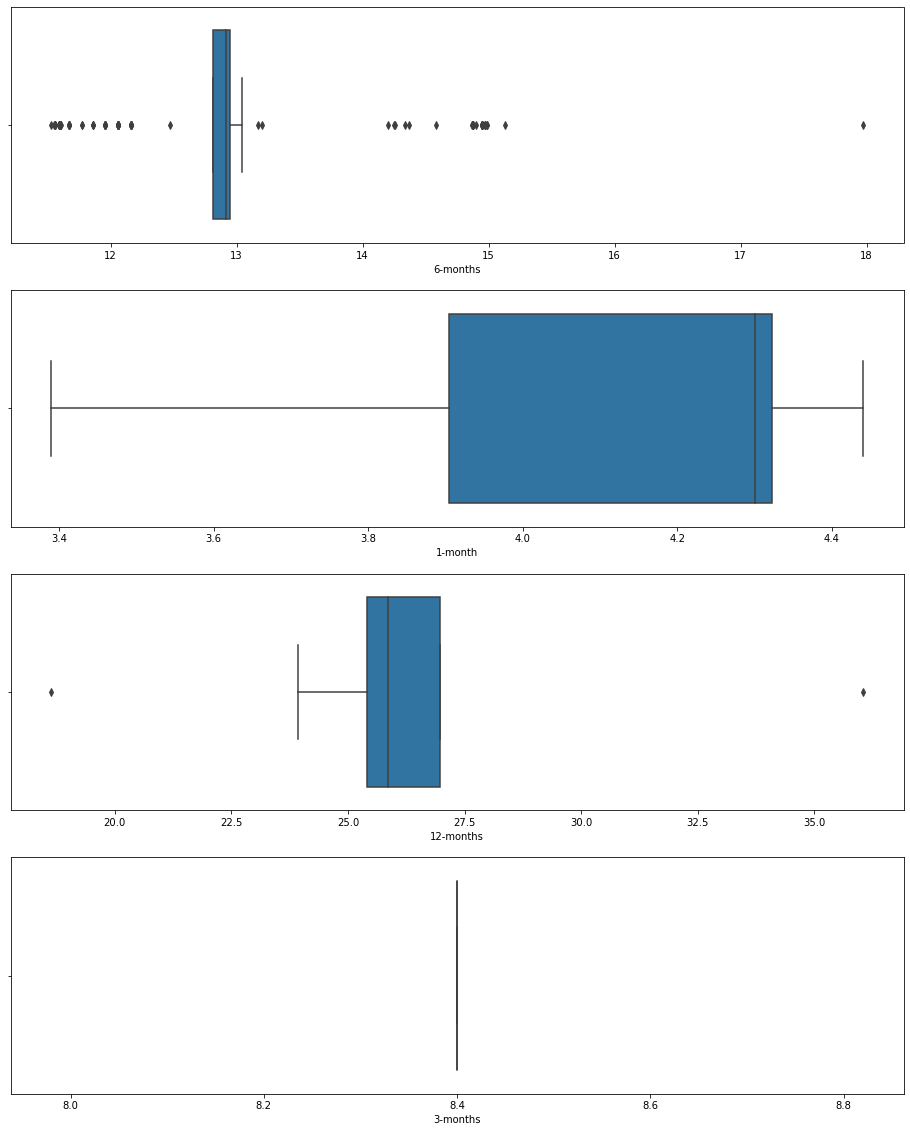

In [57]:
fig, axs = plt.subplots(4,1, figsize=(16,20))
i = 0
for val in data['plan_id_2'].unique():
    if pd.Series(val).isna().sum() == 0:
        sns.boxplot(data[ data['plan_id_2'] == val]['amount_2'], ax=axs[i])
        axs[i].set(xlabel=val)
        i += 1
pass;

In the subsequent analysis we will exclude the users whose records demonstrate implausibilities as mentioned above. When it comes to the variance in the revenues for one and the same purchase plan, we will deal with this later, as we formulate the exact goal of our A/B test:

In [58]:
# leave out implausible data by dropping implausible rows
data_plaus = data.drop(index=implaus_idx_1 + implaus_idx_2.tolist() + implaus_idx_3.tolist()+ implaus_idx_4.tolist())

For the sake of completeness let us have a look at the distribution of the signup and assignment dates in the "plausible" dataset. We see that they are distributed roughly uniformly throughout the biggest part of June 2019. The histograms almost coincide because we efffectively ensured that the signup timestamp almost coincides with the assignment timestamp.

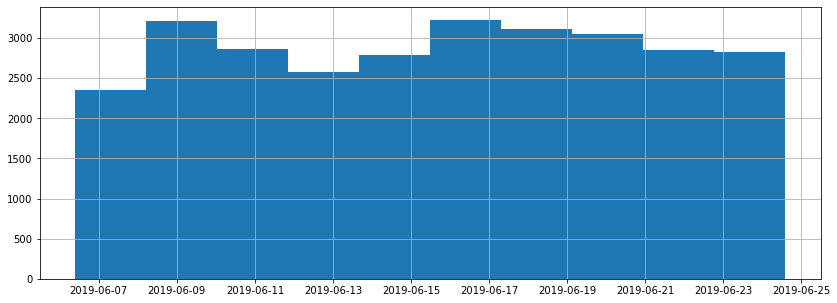

In [59]:
fig, axs = plt.subplots(figsize=(14, 5))
data_plaus['signup_date'].hist(ax=axs);

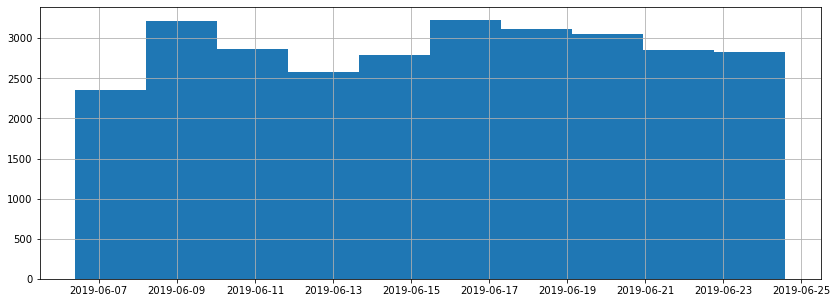

In [60]:
fig, axs = plt.subplots(figsize=(14, 5))
data_plaus['assigned_at'].hist(ax=axs);

## 3. A/B test

The goal of an A/B test is to compare two groups of users whose offered user experience or interface differs in only one aspect. In our situation the difference is the presence or the absence of a trial subscription. What we care about ultimately (and what we have data on) is whether a user makes a "real" purchase and pays for the product. He can do this immediately after the trial period or some time later, he can also pay at the very beginning and forgo the trial period completely (and of course he can just pay if he is not offered any trial). What matters is the real purchase. We will hypothesise that the trial option should favourably influence the user and will increase the users' overall willingness to purchase the product because we expect that there are more people who like the product, but would otherwise not subscribe because they are afraid they wouldn't like the product than the people who confidently subscribe right away and then realise they want to cancel the subscription (we assume that the people who subscribe immediately really understand what they do). 
This means that net effect of the trial option should be positive at least in terms of the number of subscriptions. We deliberately ignore revenues for now. In the ideal world we would have numerous users who sign up every day. We then would choose, say, 20000 users who subscribed on the same day, split them into two groups, offered a trial option on signup to one of the groups, and would see what percentage of the users converted (made a real purchase) within a certain period of time. It is clear that we cannot expect an effect to be reliably estimated within a short timeframe. At the same time we cannot wait forever to make a conclusion. A good practice is to observe both percentages over time for some time, analyse possible trend of the difference between them and make a conclusion about its significance based on appropriate statistical tests.

In our case we don't have enough users who signed up on one and the same day, which is why in our sample the signup date ranges from the beginning to the end of June. This is also why it seems that we cannot guarantee that all users will be exposed to the same test conditions apart from the presence of the trial option, but we still have to assume this. And we have to imagine that we start the test for each user at the same moment of time (we virtually shift all signup timestamps so that they coincide) and we have to compare the results for each user the same number of days after his signup (say, 5, 10, 15 days after the signup of each user). We will refer to these time intervals as time deltas or just deltas.

After we have analysed simple conversion rates, which we define as the number of users in a given group who within a given time delta after the signup made a "real" purchase divided by the total number of the users in this group, for whom we have data history at least of the length of the time delta, we go on to analyse monetary values. From the data available to us we could not identify the reason for different revenues associated with the same purchase plan. In a real business situation we will again need to clarify this before going on without making any assumptions, but having only limited information we will take a conservative approach and assume that one purchase plan always corresponds to one monetary amount. We will also assume that if a purchase plan assumes monthly payments, it cannot be cancelled, so all scheduled payments will be received. In such cases we will also ignore the time value of the money and will just sum all regular payments without discounting them as if the whole payment were received at the time of the purchase. 
The test itself will consist in comparing the average revenue of the treatment and control groups over a given time delta, where average is calculated across the whole group, for which we have a data history at least of the length of the time delta, which of course also includes the users who didn't make any purchase. Similarly, we will calculate the difference between the average revenue of the two groups, analyse it over time and judge its significance based on statistical tests. 

We are not sure if the prolongation effects (of e.g. 1-month subscriptions) are reflected in the table. Ideally, we should take into account all revenue generated by one user over the given time span. But we are limited to using the data that we have and to assuming that it reflects all revenue generated by each user that we need to know of.

We should note that the price plans should in fact not change between the A/B test period and the period after that where the results of the tests are applied (i.e. the same price plans should be offered to users and the price and the offerngs themselves should not change either). This is because if the price plans change, the users's behaviour can change as well, so there is no guarantee the results of the test will still be valid under new conditions. We in fact do see some evidence of the opposite: we don't see an option to purchase a 6-month plan at the moment on the company website.

To neutralise the effect of possible price changes, we will use the currently available price plans (the information on that is received by creating an account on the company website): 1 month: €19.99, 12 months: €9.99 per month, lifetime: €329.99. In this case we will be able to make our test somewhat forward-looking and relevant for any future time period, in which the current prices are valid (full relevance is not possible because some of the choices made in the past are apparently impossible now, such as a 6-month plan). We will also need prices for 3-month and 6-month plans, which we will derive ourselves based on the following assumptions: since the 12-month plan is valued roughly 6 times as high as the monthly plan (12* €10 = €20 * 6), we assume that the 6-month plan is worth 3 monthly plans (€60), and the 3-month plan is worth 1.5 monthly plans (€30). For the 1-month, 12-month and lifetime plans we will use rounded figures: €20, €120 and €330.

Let us create the column for the total amount paid (amount_1 + amount_2), but we know that a non-zero number can be only in one of the two columns. 

In [61]:
data_plaus['total_amount'] = data_plaus['amount_1'] + data_plaus['amount_2']
# a true/false column to identify positive revenues or conversion cases
data_plaus['pos_revenue'] = data_plaus['total_amount'] > 0

In [62]:
# let us group data_plaus by treatment/control group and do some aggregation
# pos_revenue is a boolean variable
proportion_test_summary = data_plaus[['variant', 'pos_revenue']].groupby('variant').agg(
{'pos_revenue': ['mean', 'count', 'sum']}

)
proportion_test_summary['pos_revenue']

,mean,count,sum
variant,,,
CONTROL,0.031298,14314,448.0
TREATMENT,0.041933,14571,611.0


Using all data that we have we can conclude that the conversion rate (column "mean") of the treatment group who converted (4.2%) is higher than the conversion rate of the control group. But this comparison is not reliable because doesn't "provide" all users equal time to make a purchase. Let us investigate the difference between the conversion rate over time as we described above.

Let us create a column 'purchase_timestamp' that indicates the timestamp for each "real" purchase (if it took place). It will correspond to the the value purchased_at_2 or, if there is not purchase 2, to the value purchased_at_1, but only if it was a "sale". For all users that didn't make any purchase we will fill this column with the timestamp of the last purchase across all users known to us. For the users without a purchase it will not denote the date of a purchase, but will help us define the time period during which a conversion definitely didn't take place. Here we implcitly make an assumption that the timestamp of the last purchase across all users known to us is effecively the last timestamp processed in the database. So we can treat absence of information on purchases as absence of purchases only until this datastamp. They theoretically could occur after this timestamp.

In [63]:
# values for the users who made 2 purchases
data_plaus.loc[data_plaus['purchased_at_2'].notna(), 'purchase_timestamp'] = \
        data_plaus.loc[data_plaus['purchased_at_2'].notna(), 'purchased_at_2']
# values for the users who made one "real" purchase
data_plaus.loc[(data_plaus['purchase_type_1'] == 'sale'), 'purchase_timestamp'] = \
    data_plaus.loc[ (data_plaus['purchase_type_1'] == 'sale'), 'purchased_at_1']

In [64]:
# last purchase known to us - assume it equivalent to the last moment in time reflected in the data
data_plaus['purchase_timestamp'].max()

Timestamp('2019-12-11 17:47:30')

In [65]:
data_plaus['purchase_timestamp'].fillna(data_plaus['purchase_timestamp'].max(), inplace=True)

In [66]:
# time difference between 'real' purchase and signup
data_plaus['purchase_signup_timedelta'] = data_plaus['purchase_timestamp'] - data_plaus['signup_date']

Besides, for every user will also create a column that tells how much time elapsed for each user from the signup to the last moment in time reflected in the data

In [67]:
data_plaus['overall_timedelta'] = data_plaus['purchase_timestamp'].max() - data_plaus['signup_date']

In [68]:
data_plaus['overall_timedelta'].max()

Timedelta('188 days 08:15:37.020000')

In [69]:
# we will consider the following time deltas (time frames elapsed since the singup)
timedeltas = pd.timedelta_range(start='5 day', end='185 day', freq='5D')

In [70]:
# Let us create a new dataframe for the dynamic results of the conversion rate comparison
dynamic_res = pd.DataFrame(timedeltas, columns=['timedelta'])
dynamic_res['count_treat'] = np.nan  # number of treatment users having data history longer than the time delta
dynamic_res['count_control'] = np.nan # same for the control group
dynamic_res['count_purch_treat'] = np.nan  # number of treatment users having data history longer than the time delta
                                           # who also made a real purchase within this time delta
dynamic_res['count_purch_control'] = np.nan # same for the control group
dynamic_res['proportion_purch_treat'] = np.nan   # proportion of the treatment users who made a purchase
dynamic_res['proportion_purch_control'] = np.nan # same for the control group

for i, delta in enumerate(timedeltas):
    data_plaus_subset = data_plaus[data_plaus['overall_timedelta'] > delta].copy()
                                   
    dynamic_res.loc[i,'count_treat'] = ((data_plaus_subset['variant'] == 'TREATMENT') ).sum()
    dynamic_res.loc[i,'count_control'] = ((data_plaus_subset['variant'] == 'CONTROL') ).sum()
    dynamic_res.loc[i,'count_purch_treat'] = ((data_plaus_subset['variant'] == 'TREATMENT') & (data_plaus_subset['purchase_signup_timedelta'] < delta)).sum()
    dynamic_res.loc[i,'count_purch_control'] = ((data_plaus_subset['variant'] == 'CONTROL') & (data_plaus_subset['purchase_signup_timedelta'] < delta)).sum()
    dynamic_res.loc[i,'proportion_purch_treat'] = dynamic_res['count_purch_treat'].iloc[i] / dynamic_res['count_treat'].iloc[i]
    dynamic_res.loc[i,'proportion_purch_control'] = dynamic_res['count_purch_control'].iloc[i] / dynamic_res['count_control'].iloc[i]


In [71]:
dynamic_res['diff_proportion_purch'] = dynamic_res['proportion_purch_treat'] - dynamic_res['proportion_purch_control']

In [72]:
dynamic_res.head()
dynamic_res.tail()

,timedelta,count_treat,count_control,count_purch_treat,count_purch_control,proportion_purch_treat,proportion_purch_control,diff_proportion_purch
0,5 days,14571.0,14314.0,185.0,328.0,0.012696,0.022915,-0.010218
1,10 days,14571.0,14314.0,484.0,353.0,0.033217,0.024661,0.008555
2,15 days,14571.0,14314.0,504.0,365.0,0.034589,0.025500,0.009090
3,20 days,14571.0,14314.0,516.0,376.0,0.035413,0.026268,0.009145
4,25 days,14571.0,14314.0,522.0,378.0,0.035825,0.026408,0.009417


,timedelta,count_treat,count_control,count_purch_treat,count_purch_control,proportion_purch_treat,proportion_purch_control,diff_proportion_purch
32,165 days,14571.0,14314.0,604.0,439.0,0.041452,0.030669,0.010783
33,170 days,14571.0,14314.0,608.0,442.0,0.041727,0.030879,0.010848
34,175 days,10656.0,10397.0,427.0,312.0,0.040071,0.030009,0.010063
35,180 days,6423.0,6198.0,260.0,192.0,0.040480,0.030978,0.009502
36,185 days,2513.0,2441.0,98.0,75.0,0.038997,0.030725,0.008272


A few comments on the resulting table. It makes sense that 5, 10, ...25 etc.  days of history are available for all users. It turns out that even 170 days of data history is available for all users (see columns count_treat and count_control). But a longer history is available for fewer users. We also see that the number of the users that made a purchase increases as long as the considered time period widens and as long as the total number of users stays the same. 

Let us depict the conversion rates for the two groups and their difference. We see indeed that the two rate indeed increase monotonously before the number of users, for which such a corresponding amount of data history is available, starts to decrease.

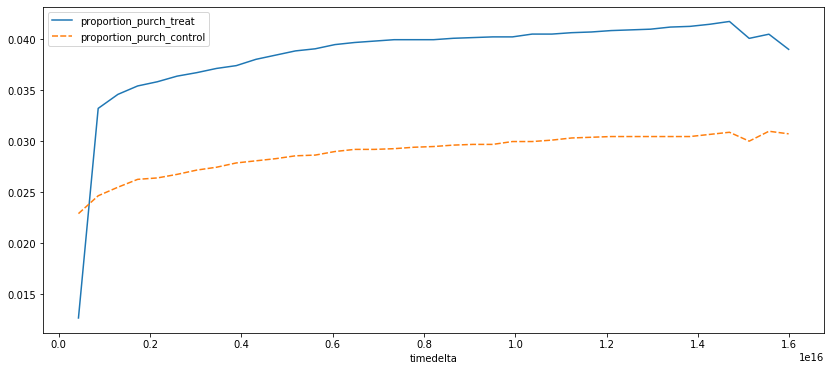

In [73]:
fig, axs = plt.subplots(figsize=(14, 6))
sns.lineplot(data=dynamic_res[['proportion_purch_treat', 
                               'proportion_purch_control', 'timedelta']].set_index('timedelta'));

The difference between the treatment and control conversion rates quickly gets positive and levels off at around 1 percentage point for the most of the timedeltas range.

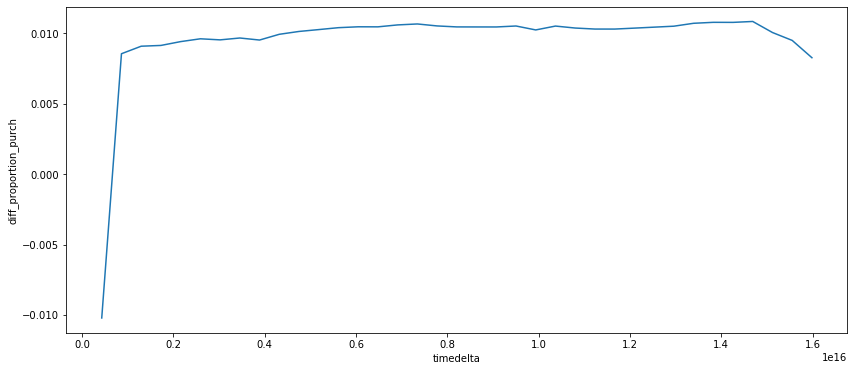

In [74]:
fig, axs = plt.subplots(figsize=(14, 6))
sns.lineplot(x='timedelta', y='diff_proportion_purch', data=dynamic_res);

Now for each value of the difference we have to judge its statistical significance. We will use a conventional test for proportions based on normal (z) test. We will consider its assumptions fulfilled (we assume randomness and independence of the samples, and the sample size guarantees via the central limit theorem that the proportions are approximately normally distributed). We will save the results in the same dataframe dynamic_res.

The test is constructed so that the null hypothesis is that both conversion rates are equal. As the alternative hypothesis we will consider a one-sided hypothesis that treatment conversion rate is larger than the control conversion rate (our preferred outcome).

In [75]:
dynamic_res['proportions_test_stat'] = np.nan
dynamic_res['proportions_test_pvalue'] = np.nan
# we choose alternative='larger', so variables relating to treatment come first
for i in np.arange(dynamic_res.shape[0]):
    stat, pvalue = proportions_ztest(
                  count=(dynamic_res['count_purch_treat'].iloc[i], dynamic_res['count_purch_control'].iloc[i]), 
                  nobs=(dynamic_res['count_treat'].iloc[i], dynamic_res['count_control'].iloc[i]),
                  value=0, alternative='larger', prop_var=False)
    dynamic_res.loc[i, 'proportions_test_stat'] = stat
    dynamic_res.loc[i, 'proportions_test_pvalue'] = pvalue

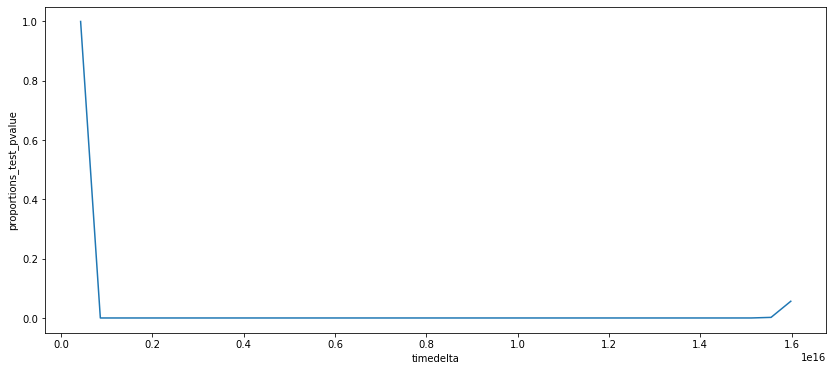

In [76]:
fig, axs = plt.subplots(figsize=(14, 6))
sns.lineplot(x='timedelta', y='proportions_test_pvalue', data=dynamic_res);

In [77]:
dynamic_res['proportions_test_pvalue'].head()
dynamic_res['proportions_test_pvalue'].tail()

0    1.000000
1    0.000007
2    0.000003
3    0.000004
4    0.000002
Name: proportions_test_pvalue, dtype: float64

32    4.521349e-07
33    4.215853e-07
34    3.647664e-05
35    2.040864e-03
36    5.641589e-02
Name: proportions_test_pvalue, dtype: float64

For a majority of timedeltas the p-values are well below the conventional significance level of 5%. This allows us to reject the null hypothesis in favour of our preferred alternative one (the conversion rate in the treatment group is significantly higher than that of the control group).

Now that we have compared the conversion rates of the two groups, let us compare the average revenues. We will perform the comparison and the tests for the same timedeltas as before.

First, let us create a column that contains the information on the type ("plan") of the "real" purchase if such as purchase took place.

In [78]:
# for the users with two purchases it is the one corresponding to the second one
data_plaus.loc[data_plaus['plan_id_2'].notna(), 'plan_ult_sale'] = data_plaus.loc[data_plaus['plan_id_2'].notna(), 'plan_id_2']

# for the users with only one purchase, it is the one corresponding to it, but only if it is a "real" sale
data_plaus.loc[(data_plaus['plan_id_1'].notna()) & 
               (data_plaus['purchase_type_1'] == 'sale'), 'plan_ult_sale'] = data_plaus.loc[(data_plaus['plan_id_1'].notna()) & 
               (data_plaus['purchase_type_1'] == 'sale'), 'plan_id_1']

Now let us assign each purchase plan a revenue based on the assumptions we made above

In [79]:
data_plaus['plan_est_revenue'] = data_plaus['plan_ult_sale'].map({
    np.nan: 0,
    '1-month': 20, 
    '3-months': 30, 
    '6-months': 60, 
    '12-months': 120,
    'lifetime': 330
})

In [80]:
data_plaus['plan_est_revenue'].value_counts(dropna=False)

0      27826
20       477
60       318
120      258
330        5
30         1
Name: plan_est_revenue, dtype: int64

In [81]:
# Let us further expand the existing dataframe dynamic_res
dynamic_res['total_rev_treat'] = np.nan
dynamic_res['total_rev_control'] = np.nan
dynamic_res['ave_rev_treat'] = np.nan
dynamic_res['ave_rev_control'] = np.nan

for i, delta in enumerate(timedeltas):
    data_plaus_subset = data_plaus[data_plaus['overall_timedelta'] > delta].copy()
                                   
    dynamic_res.loc[i, 'total_rev_treat'] = data_plaus_subset[(data_plaus_subset['variant'] == 
                                    'TREATMENT' ) & (data_plaus_subset['purchase_signup_timedelta'] < delta)]['plan_est_revenue'].sum()
    dynamic_res.loc[i, 'total_rev_control'] = data_plaus_subset[(data_plaus_subset['variant'] == 
                                    'CONTROL' ) & (data_plaus_subset['purchase_signup_timedelta'] < delta)]['plan_est_revenue'].sum()
    dynamic_res.loc[i, 'ave_rev_treat'] = dynamic_res['total_rev_treat'].iloc[i] / dynamic_res['count_treat'].iloc[i]
    dynamic_res.loc[i, 'ave_rev_control'] = dynamic_res['total_rev_control'].iloc[i] / dynamic_res['count_control'].iloc[i]

Let us plot the resulting average revenues for different timedeltas

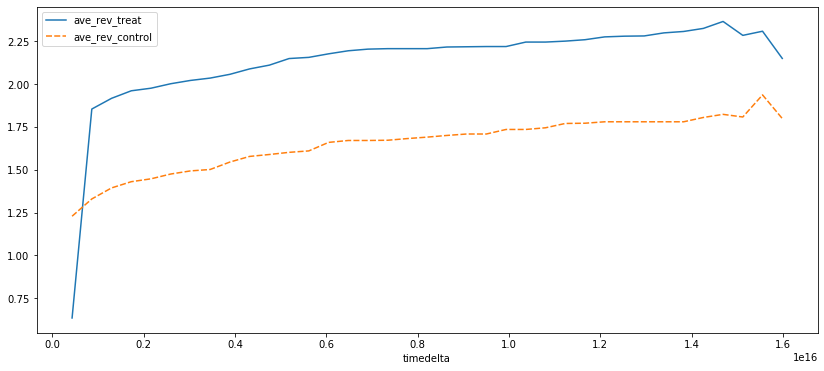

In [82]:
fig, axs = plt.subplots(figsize=(14, 6))
sns.lineplot(data=dynamic_res[['ave_rev_treat', 
                               'ave_rev_control', 'timedelta']].set_index('timedelta'));

In order to judge whether the average revenues for the treatment group are on significantly higher than those for the control group, we will carry out the Welch's t-test. This test effectively compares the means of two independent random samples. The null hypothesis of a t-test is that the means of two samples are equal. As the alternative hypothesis we will choose a one-sided hypothesis that the average revenue of the treatment group is higher than that of the control group. The Welch's t-test is an adaptation of the standard t-test and is more reliable when the two samples have unequal variances and/or unequal sample sizes. Given the size of our samples the required conditions (such as normality of the sample means) are fulfilled via the central limit theorem, and we also presume that the treatment and control samples are independent and random. 

In [83]:
dynamic_res['ave_rev_test_stat'] = np.nan
dynamic_res['ave_rev_test_pvalue'] = np.nan
# The test is constructed so that the null hypothesis is that both conversion rates are equal
# The alternative hypothesis is that treatment conversion rate is larger than the control conversion rate
# this is why we choose alternative='larger', and variables relating to treatment come first
for i, delta in enumerate(timedeltas):
    data_plaus_subset = data_plaus[data_plaus['overall_timedelta'] > delta].copy()
    
    
    # to get the right shape: all treatment users having a data history of more than time delta
    revs_treat = data_plaus_subset[(data_plaus_subset['variant'] == 
                                    'TREATMENT' ) ]['plan_est_revenue'].copy()
    # fill with zeros first
    revs_treat.iloc[:] = 0
    # now replace zeros with actual revenues if they occurred within the time delta 
    revs_treat.loc[(data_plaus_subset['variant'] == 'TREATMENT' ) & (data_plaus_subset['purchase_signup_timedelta'] < delta)] = \
                data_plaus_subset[(data_plaus_subset['variant'] == 
                                    'TREATMENT' ) & (data_plaus_subset['purchase_signup_timedelta'] < delta)]['plan_est_revenue']
    
    #same procedure for the control group
    revs_control = data_plaus_subset[(data_plaus_subset['variant'] == 
                                    'CONTROL' ) ]['plan_est_revenue'].copy()
    revs_control.iloc[:] = 0
    revs_control.loc[(data_plaus_subset['variant'] == 'CONTROL' ) & (data_plaus_subset['purchase_signup_timedelta'] < delta)] = \
                data_plaus_subset[(data_plaus_subset['variant'] == 
                                    'CONTROL' ) & (data_plaus_subset['purchase_signup_timedelta'] < delta)]['plan_est_revenue']
    stat, pvalue, _ = ttest_ind(
                 x1=revs_treat, 
                 x2=revs_control, 
                 alternative='larger', usevar='unequal', value=0)
    dynamic_res.loc[i, 'ave_rev_test_stat'] = stat
    dynamic_res.loc[i, 'ave_rev_test_pvalue'] = pvalue

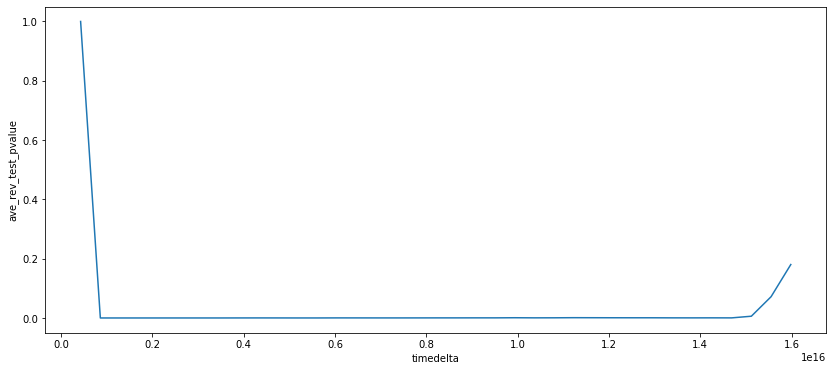

In [84]:
fig, axs = plt.subplots(figsize=(14, 6))
sns.lineplot(x='timedelta', y='ave_rev_test_pvalue', data=dynamic_res);

In [85]:
dynamic_res['ave_rev_test_pvalue'].head()
dynamic_res['ave_rev_test_pvalue'].tail()

0    1.000000
1    0.000052
2    0.000075
3    0.000071
4    0.000081
Name: ave_rev_test_pvalue, dtype: float64

32    0.000521
33    0.000378
34    0.005957
35    0.071737
36    0.180286
Name: ave_rev_test_pvalue, dtype: float64

Similarly to the proportions test, for a majority of timedeltas the p-values are well below the conventional significance levels of 5%. This allows us to reject the null hypothesis in favour of our preferred alternative one and to conclude that the average revenue in the treatment group is significantly higher than the one in the control group.

## 4. Conclusion

We can conclude that the results of the tests confirmed our hypothesis regarding the positive effect of the trial option. Both the conversion rates and average revenue are higher for the treatment group. In general, in order to make a decision whether to roll out the treatment (the trial option) to all users, we could also estimate the total positive effect of the treatment and compare it to the total associated costs. Presumably the costs will be negligible since the solution for the trial option is already developed. In this case providing the trial option to all users is very likely to have an overall positive effect, which means that this could be done immediately. Having said that we should keep in mind that this analysis contained a number of assumptions that have to be validated in a real business situation. We should also reiterate that if it turns out that other factors may have played a role in defining different behaviour of the users as the result of other A/B tests or other business decisions, this can greatly limit the quality of the obtained results.